In [2]:
#Import the necessary libraries
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential, load_model
from keras.callbacks import CSVLogger
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from array import array
import pyaudio
import wave
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
#Load the data into dataframe
#REQUIREMENTS:
    #1. Download the dataset from: https://github.com/karoldvl/ESC-50
    #2. have the dataset in the same directory as this python notebook
    
data = pd.read_csv('ESC-50-master/meta/esc50.csv')

In [4]:
print(data)

               filename  fold  target          category  esc10  src_file take
0      1-100032-A-0.wav     1       0               dog   True    100032    A
1     1-100038-A-14.wav     1      14    chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36    vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36    vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19      thunderstorm  False    101296    A
5     1-101296-B-19.wav     1      19      thunderstorm  False    101296    B
6     1-101336-A-30.wav     1      30   door_wood_knock  False    101336    A
7     1-101404-A-34.wav     1      34       can_opening  False    101404    A
8      1-103298-A-9.wav     1       9              crow  False    103298    A
9     1-103995-A-30.wav     1      30   door_wood_knock  False    103995    A
10    1-103999-A-30.wav     1      30   door_wood_knock  False    103999    A
11    1-104089-A-22.wav     1      22          clapping  False  

In [5]:
#Should be (2000,7)
data.shape

(2000, 7)

In [6]:
D = []
i = 0
#load the spectrograms and their labels into D
for row in data.itertuples():
    testFile = str(data['filename'][i])
    y, sr = librosa.load('ESC-50-master/audio/' + testFile, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    D.append((ps, row.target))
    i = i + 1

In [7]:
len(D)

2000

In [13]:
i = 0
#Loop to take the initial sound files and slow them down by a factor of .81x
#NOTE: This requires that there is a directory named TimeStretchWavFiles/slow/ in the same folder
for row in data.itertuples():
    testFile = str(data['filename'][i])
    #if testFile == "1-100032-A-0.wav" or testFile == "1-100038-A-14.wav":# or testFile == "1-100210-A-36.wav" or testFile == "1-100210-B-36.wav" or testFile == "1-101296-A-19.wav" or testFile == "1-101296-B-19.wav" or testFile == "1-101336-A-30.wav" or testFile == "1-101404-A-34.wav" or testFile == "1-103298-A-9.wav" or testFile == "1-104089-A-22.wav" or testFile == "1-104089-B-22.wav" or testFile == "1-103995-A-30.wav" or testFile == "1-103999-A-30.wav":
        #i = i
    #else:
    y, sr = librosa.load('ESC-50-master/audio/' + testFile, duration=4.97)
    y_changed = librosa.effects.time_stretch(y, rate=0.81)
    librosa.output.write_wav('TimeStretchWavFiles/slow/' + testFile, y_changed, sr)
    i = i + 1

In [14]:
i = 0
#Loop to take the initial sound files and speed them up by a factor of 1.07x
#NOTE: This requires that there is a directory named TimeStretchWavFiles/fast/ in the same folder
for row in data.itertuples():
    testFile = str(data['filename'][i])
    y, sr = librosa.load('ESC-50-master/audio/' + testFile, duration=4.97)
    y_changed = librosa.effects.time_stretch(y, rate=1.07)
    librosa.output.write_wav('TimeStretchWavFiles/fast/' + testFile, y_changed, sr)
    i = i + 1

In [15]:
i = 0
n_steps = 2 #-1, -2, 2, 1

#Loop to take the initial sound files and create new sound files that
#have had their pitch changed by 2 half steps
#NOTE: This requires that there is a directory named PitchChangeWavFiles/Change1/ in the same folder
for row in data.itertuples():
    testFile = str(data['filename'][i])
    y, sr = librosa.load('ESC-50-master/audio/' + testFile, duration=2.97)
    y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
    librosa.output.write_wav('PitchChangeWavFiles/Change1/' + testFile, y_changed, sr)
    i = i + 1

In [31]:
i = 0
#Loop to add the slowed audio clips' spectrograms to D which holds the data and their labels
for row in data.itertuples():
    testFile = str(data['filename'][i])
    y, sr = librosa.load('TimeStretchWavFiles/slow/' + testFile, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    D.append((ps, row.target))
    i = i + 1

In [32]:
i = 0
#Loop to add the quickened audio clips' spectrograms to D which holds the data and their labels
for row in data.itertuples():
    testFile = str(data['filename'][i])
    y, sr = librosa.load('TimeStretchWavFiles/fast/' + testFile, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    D.append((ps, row.target))
    i = i + 1

In [33]:
i = 0
#Loop to add the 2-half step audio clips' spectrograms to D which holds the data and their labels
for row in data.itertuples():
    testFile = str(data['filename'][i])
    y, sr = librosa.load('PitchChangeWavFiles/Change1/' + testFile, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    D.append((ps, row.target))
    i = i + 1

In [34]:
def GetMicRecording(filename):
    FORMAT = pyaudio.paInt16
    CHANNELS = 2
    RATE = 44100
    CHUNK = 1024
    RECORD_SECONDS = 5
    WAVE_OUTPUT_FILENAME = "RecordedFromMicrophone/" + filename
 
    audio = pyaudio.PyAudio()
 
    # start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK)
    print("recording...")
    frames = []
 
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    print("finished recording")
 
    # stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()
 
    waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()

In [35]:
def GetMicPrediction(filename):
    M = np.zeros((128,128,1))
    y, sr = librosa.load('RecordedFromMicrophone/' + filename, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    M[:,:,0] = ps
    N = np.array([M.reshape((128,128,1))])
    c = model2.predict_classes(N)
    classes = model2.predict(N)
    return c, classes

In [36]:
def GetClassFromIndex(c):
    t = data[data['target'] == c[0]]             
    t = t['category']
    t = np.array(t)
    return t[0]

In [37]:
def RunDemo(filename):
    GetMicRecording(filename)
    c, classes = GetMicPrediction(filename)
    className = GetClassFromIndex(c)
    print("My Guess: " + className)
    classesSorted = np.sort(classes.copy())
    
    
    classesSorted = np.matrix(classesSorted)
    for i in [49,48,47,46,45,44,43,42,41,40]:        
        temp = np.where(classes == classesSorted[0,i])[1]
        t = GetClassFromIndex(temp)
        print(format(classesSorted[0,i], 'f') + " " + t)

#RunDemo('recording1.wav')


In [38]:
#Split the dataset into training and testing sets
dataset = D
random.shuffle(dataset)

train = dataset[:6000]
val = dataset[6000:6500]
test = dataset[6500:]

X_train, y_train = zip(*train)
X_val, y_val = zip(*val)
X_test, y_test = zip(*test)

X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

#One hot encode the labels
y_train = np.array(keras.utils.to_categorical(y_train, 50))
y_test = np.array(keras.utils.to_categorical(y_test, 50))

In [39]:
len(D)

8000

In [46]:

#Build the CNN by adding the layers to our model. The input shape is the size of our images
#as they are sent to the first convolutional layer
model3 = Sequential()
input_shape=(128, 128, 1)

model3.add(Conv2D(36, (3, 3), strides=(1, 1), padding = "same", input_shape=input_shape))
model3.add(MaxPooling2D((2, 2), strides=(2, 2)))
model3.add(Activation('relu'))

model3.add(Conv2D(48, (3, 3), padding="same", strides=(1,1)))
model3.add(MaxPooling2D((2, 2), strides=(2, 2)))
model3.add(Activation('relu'))

model3.add(Conv2D(48, (3, 3), padding="same", strides=(1,1)))
model3.add(Activation('relu'))

model3.add(Flatten())
model3.add(Dropout(rate=0.3))

model3.add(Dense(100))
model3.add(Activation('relu'))
model3.add(Dropout(rate=0.3))

model3.add(Dense(50))
model3.add(Activation('softmax'))


In [47]:
earlyStop = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [48]:
#This is where the model will be compiled and tested. The results will be saved as a comma
#seperated list, where we will then be able to plot them. This will allow us to visualize
#how our model is running. 
csv_logger = CSVLogger('FinalSmallStrides.csv', append=True, separator=',')

model3.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=['accuracy'])

model3.fit(
    x=X_train, 
    y=y_train,
    epochs=100,
    batch_size=128,
    validation_data= (X_val, y_val),
    callbacks=[csv_logger, earlyStop])

score3 = model3.evaluate(
    x=X_test,
    y=y_test)

print('Test loss:', score3[0])
print('Test accuracy:', score3[1])
model3.save('Models/finalModel.h5')

Train on 6000 samples, validate on 2000 samples
Epoch 1/100
6000/6000 [==============================] - 79s 13ms/step - loss: 4.0664 - acc: 0.0923 - val_loss: 3.3391 - val_acc: 0.1970
Epoch 2/100
6000/6000 [==============================] - 79s 13ms/step - loss: 3.0068 - acc: 0.2478 - val_loss: 2.7244 - val_acc: 0.3435
Epoch 3/100
6000/6000 [==============================] - 81s 13ms/step - loss: 2.3259 - acc: 0.4038 - val_loss: 2.3798 - val_acc: 0.4100
Epoch 4/100
6000/6000 [==============================] - 83s 14ms/step - loss: 1.9974 - acc: 0.4997 - val_loss: 2.2916 - val_acc: 0.4495
Epoch 5/100
6000/6000 [==============================] - 78s 13ms/step - loss: 1.6868 - acc: 0.5687 - val_loss: 2.2062 - val_acc: 0.4990
Epoch 6/100
6000/6000 [==============================] - 81s 13ms/step - loss: 1.5100 - acc: 0.6225 - val_loss: 2.1537 - val_acc: 0.5320
Epoch 7/100
6000/6000 [==============================] - 76s 13ms/step - loss: 1.4419 - acc: 0.6408 - val_loss: 2.1464 - val_acc: 

In [56]:
resultData = pd.read_csv('FinalSmallStrides.csv', sep = ",")
resultData = resultData[14:44+12]
resultData

,epoch,acc,loss,val_acc,val_loss
14,0,0.092333,4.066403,0.1970,3.339097
15,1,0.247833,3.006841,0.3435,2.724380
16,2,0.403833,2.325916,0.4100,2.379780
17,3,0.499667,1.997397,0.4495,2.291622
18,4,0.568667,1.686750,0.4990,2.206242
19,5,0.622500,1.510025,0.5320,2.153747
20,6,0.640833,1.441919,0.5300,2.146388
21,7,0.675667,1.302198,0.5395,2.234451
22,8,0.696667,1.233044,0.5455,2.223109
23,9,0.722333,1.096892,0.6015,1.930653


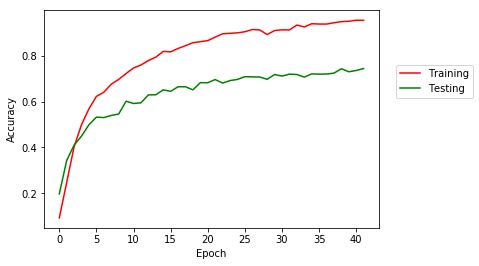

In [59]:
plt.plot(resultData['epoch'], resultData['acc'], color = 'red', label = "Training")
plt.plot(resultData['epoch'], resultData['val_acc'], color = 'green', label = "Testing")
plt.xticks(np.arange(0, 41, step=5))
plt.legend(bbox_to_anchor=(1.05, .75), loc=2, borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

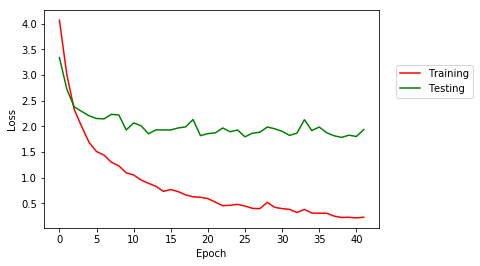

In [60]:
plt.plot(resultData['epoch'], resultData['loss'], color = 'red', label = "Training")
plt.plot(resultData['epoch'], resultData['val_loss'], color = 'green', label = "Testing")
plt.xticks(np.arange(0, 41, step=5))
plt.legend(bbox_to_anchor=(1.05, .75), loc=2, borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()